In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
from itertools import combinations 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [44]:
data = pd.read_csv(r"C:\Users\Asus\Desktop\Herst doc\Final project\data_banknote_authentication.txt", header=None)
data.columns = ['var', 'skew', 'curt', 'entr', 'auth']
print(data.head())

       var    skew    curt     entr  auth
0  3.62160  8.6661 -2.8073 -0.44699     0
1  4.54590  8.1674 -2.4586 -1.46210     0
2  3.86600 -2.6383  1.9242  0.10645     0
3  3.45660  9.5228 -4.0112 -3.59440     0
4  0.32924 -4.4552  4.5718 -0.98880     0


In [45]:

# Count total records, fake notes, and genuine notes
n_records = len(data)
n_fake_notes = len(data[data['auth'] == 0])  # 0 = Fake notes
n_real_notes = len(data[data['auth'] == 1])  # 1 = Genuine notes

# Display results
print("Total number of records: {}".format(n_records))
print("Total number of fake notes: {}".format(n_fake_notes))
print("Total number of real notes: {}".format(n_real_notes))

# Check for missing values
missing_values = data.isnull().sum().sum()
if missing_values == 0:
    print("\nThere are no missing values in the dataset")
else:
    print("\nThe dataset has {} missing values".format(missing_values))

Total number of records: 1372
Total number of fake notes: 762
Total number of real notes: 610

There are no missing values in the dataset


In [46]:
display(data.describe())

,var,skew,curt,entr,auth
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


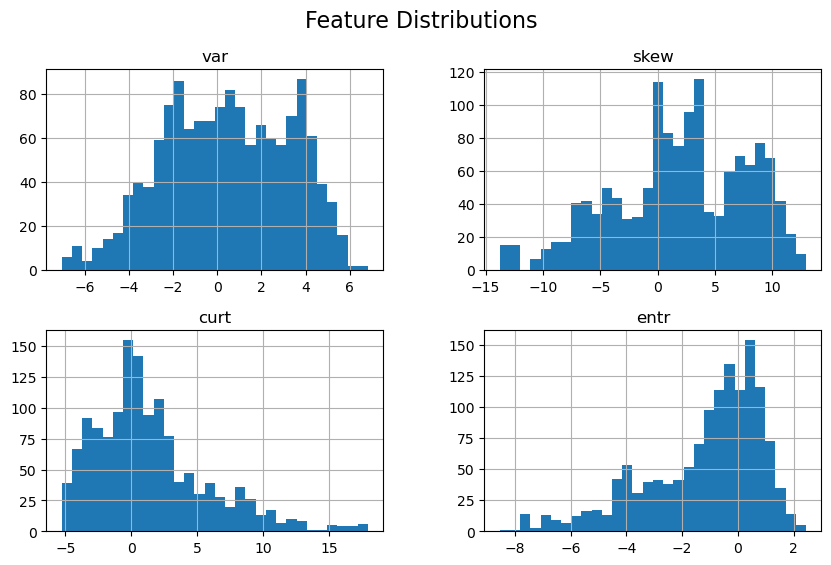

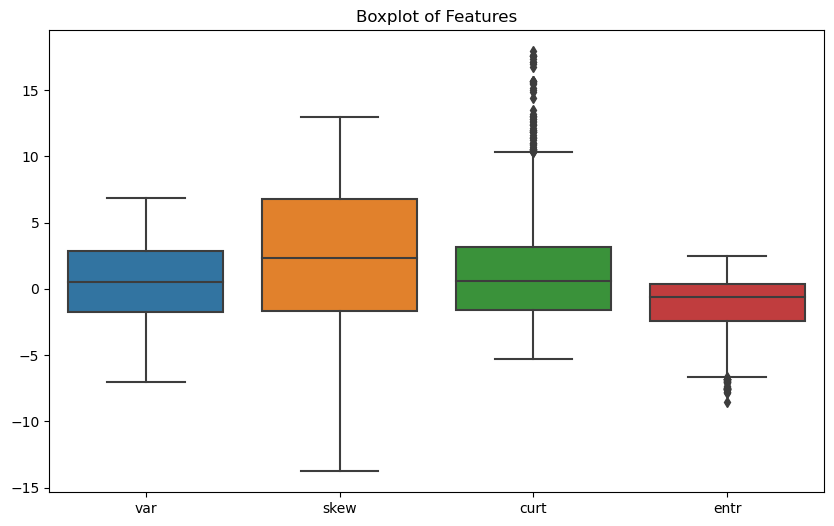

In [47]:
# Plot histograms for all features
data.drop(columns=['auth']).hist(figsize=(10, 6), bins=30)
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()

# Plot boxplots to check for outliers
plt.figure(figsize=(10, 6))
sns.boxplot(data=data.drop(columns=['auth']))
plt.title("Boxplot of Features")
plt.show()

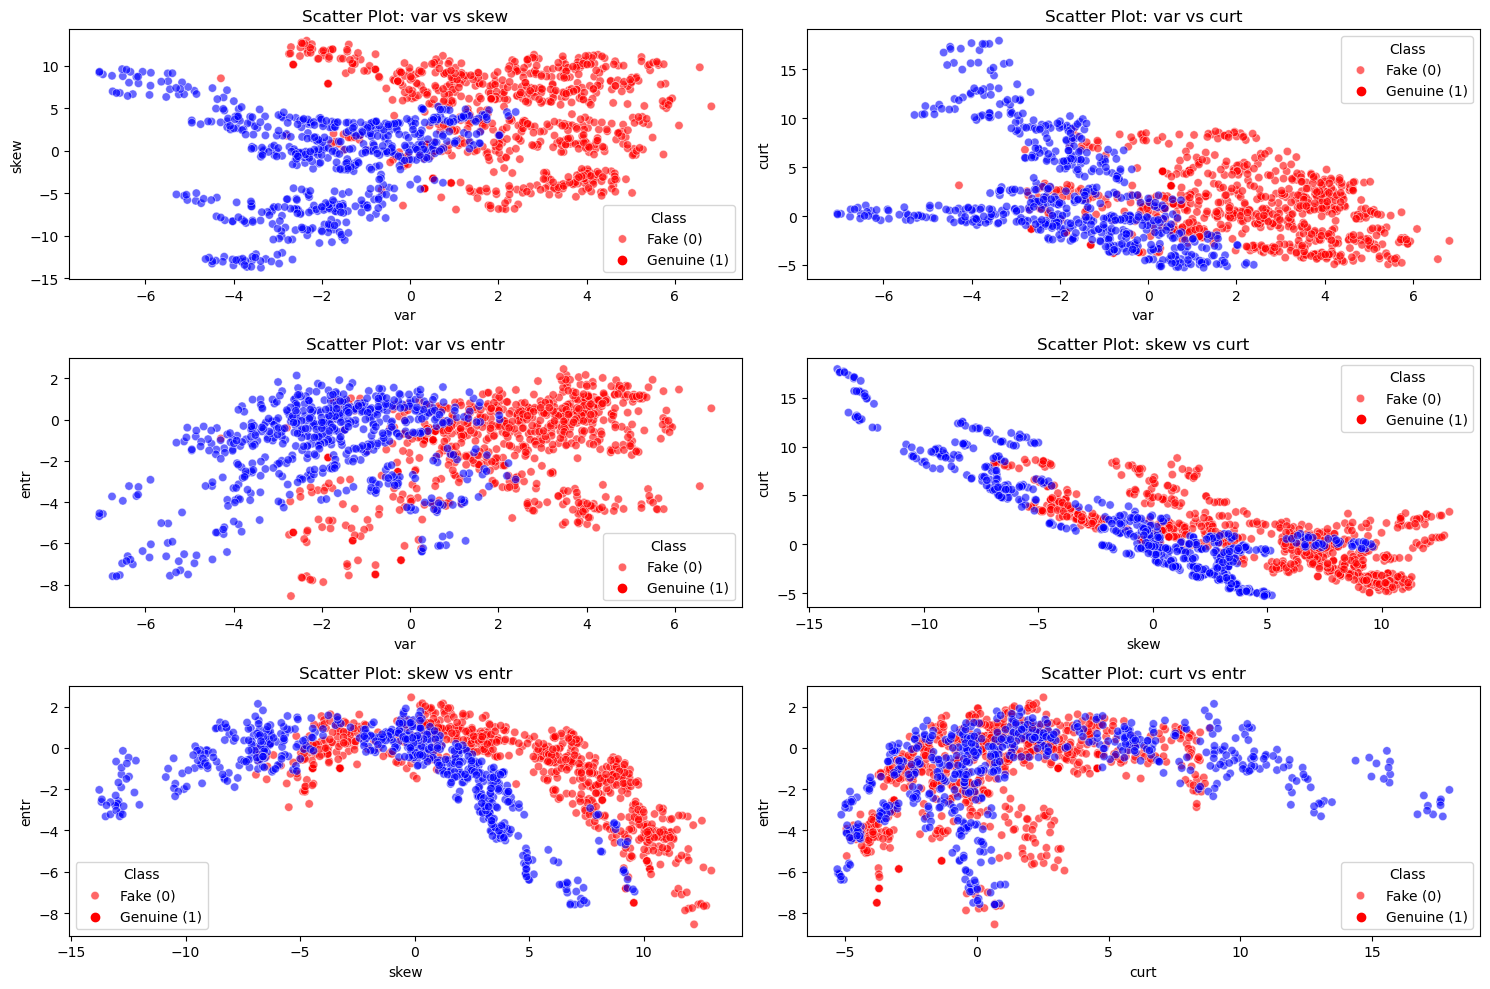

In [48]:

# Define feature pairs for scatter plots
feature_pairs = list(combinations(['var', 'skew', 'curt', 'entr'], 2))

# Plot scatter plots for each pair of features
plt.figure(figsize=(15, 10))
for i, (feature_x, feature_y) in enumerate(feature_pairs, 1):
    plt.subplot(3, 2, i)
    sns.scatterplot(data=data, x=feature_x, y=feature_y, hue='auth', palette={0: "red", 1: "blue"}, alpha=0.6)
    plt.title(f'Scatter Plot: {feature_x} vs {feature_y}')
    plt.legend(title="Class", labels=["Fake (0)", "Genuine (1)"])

plt.tight_layout()
plt.show()

In [49]:

# Separate features and target
X = data.drop(columns=['auth'])  # Numerical features
y = data['auth']  # Target variable

# Apply Min-Max Scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Convert scaled data back into a DataFrame
data_scaled = pd.DataFrame(X_scaled, columns=X.columns)
data_scaled['auth'] = y  # Add target column back

# Display first few rows of scaled data
print(data_scaled.head())

        var      skew      curt      entr  auth
0  0.769004  0.839643  0.106783  0.736628     0
1  0.835659  0.820982  0.121804  0.644326     0
2  0.786629  0.416648  0.310608  0.786951     0
3  0.757105  0.871699  0.054921  0.450440     0
4  0.531578  0.348662  0.424662  0.687362     0


In [50]:
# Split features and target variable
X = data.drop(columns=['auth'])  # Features
y = data['auth']  # Target variable (0: Fake, 1: Genuine)

# Split data into training and testing sets (40% test, 60% train)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=5)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 823 samples.
Testing set has 549 samples.


We have chosen the following supervised learning models to build the trained models:

Support Vector Machines (SVM)
Gradient Boosting, an ensemble method
K-Nearest Neighbors (KNeighbors)

In [51]:

import time
from sklearn.metrics import fbeta_score, accuracy_score, confusion_matrix




# Function to train and evaluate a model
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    """
    Trains and evaluates a machine learning model.

    Parameters:
       - learner: The learning algorithm (e.g., DecisionTree, SVM, etc.)
       - sample_size: Number of samples to use from the training set
       - X_train: Training features
       - y_train: Training labels
       - X_test: Testing features
       - y_test: Testing labels

    Returns:
       - results: Dictionary containing accuracy, F-score, training time, prediction time, and confusion matrix.
    """

    results = {}
    beta = 2  # Weight for F-beta score
    
    # Train the learner
    start = time.time()
    learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time.time()
    results['train_time'] = end - start
    
    # Make predictions
    start = time.time()
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])  # Use first 300 training samples
    end = time.time()
    results['pred_time'] = end - start
    
    # Compute accuracy scores
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F-beta scores
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta=beta)
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=beta)
    
    # Compute Confusion Matrix
    results['conf_mat'] = confusion_matrix(y_test, predictions_test)
    
    # Output the results
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
    
    return results



KNeighborsClassifier trained on 42 samples.
Best parameters: {'n_neighbors': 3, 'weights': 'uniform'}

KNeighborsClassifier trained on 165 samples.
Best parameters: {'n_neighbors': 3, 'weights': 'uniform'}

KNeighborsClassifier trained on 823 samples.
Best parameters: {'n_neighbors': 3, 'weights': 'distance'}

SVC trained on 42 samples.
Best parameters: {'C': 0.1, 'kernel': 'linear'}

SVC trained on 165 samples.
Best parameters: {'C': 0.1, 'kernel': 'linear'}

SVC trained on 823 samples.
Best parameters: {'C': 10, 'kernel': 'rbf'}

GradientBoostingClassifier trained on 42 samples.
Best parameters: {'learning_rate': 0.01, 'n_estimators': 50}

GradientBoostingClassifier trained on 165 samples.
Best parameters: {'learning_rate': 0.1, 'n_estimators': 100}

GradientBoostingClassifier trained on 823 samples.
Best parameters: {'learning_rate': 0.1, 'n_estimators': 100}


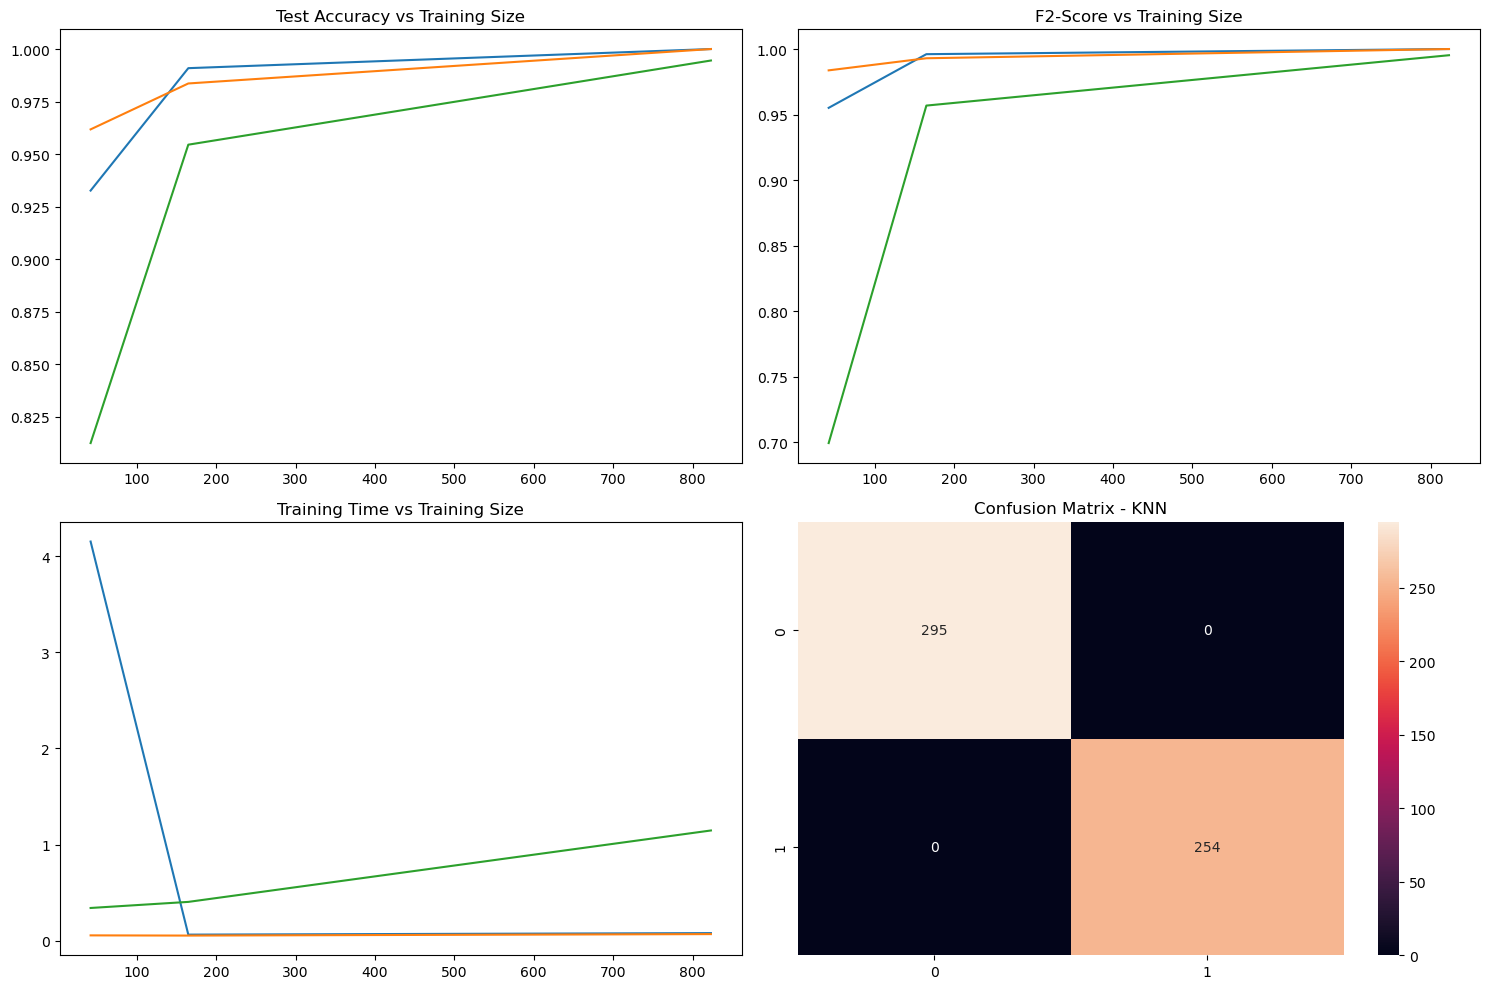


=== Final Model Comparison ===

KNN:
Best Test Accuracy: 1.000
Best F2-Score: 1.000
Training Time: 0.08s
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       295
           1       1.00      1.00      1.00       254

    accuracy                           1.00       549
   macro avg       1.00      1.00      1.00       549
weighted avg       1.00      1.00      1.00       549


SVM:
Best Test Accuracy: 1.000
Best F2-Score: 1.000
Training Time: 0.07s
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       295
           1       1.00      1.00      1.00       254

    accuracy                           1.00       549
   macro avg       1.00      1.00      1.00       549
weighted avg       1.00      1.00      1.00       549


GradientBoosting:
Best Test Accuracy: 0.995
Best F2-Score: 0.995
Training Time: 1.15s
Classification Report:
          

In [57]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from math import ceil
import time
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Enhanced training function with hyperparameter tuning
def train_predict(learner, param_grid, sample_size, X_train, y_train, X_test, y_test):
    """
    Enhanced version with hyperparameter tuning and detailed metrics
    """
    results = {}
    beta = 2  # Consider adjusting beta based on your class imbalance
    
    # Hyperparameter tuning
    grid_search = GridSearchCV(learner, param_grid, cv=3, n_jobs=-1)
    
    # Training with timing
    start = time.time()
    grid_search.fit(X_train[:sample_size], y_train[:sample_size])
    end = time.time()
    
    results.update({
        'train_time': end - start,
        'best_params': grid_search.best_params_,
        'best_estimator': grid_search.best_estimator_
    })

    # Prediction timing
    start = time.time()
    best_model = grid_search.best_estimator_
    predictions_test = best_model.predict(X_test)
    predictions_train = best_model.predict(X_train[:300])
    end = time.time()
    
    results['pred_time'] = end - start

    # Enhanced metrics
    results.update({
        'acc_train': accuracy_score(y_train[:300], predictions_train),
        'acc_test': accuracy_score(y_test, predictions_test),
        'f_train': fbeta_score(y_train[:300], predictions_train, beta=beta),
        'f_test': fbeta_score(y_test, predictions_test, beta=beta),
        'classification_report': classification_report(y_test, predictions_test),
        'conf_mat': confusion_matrix(y_test, predictions_test)
    })

    print(f"\n{learner.__class__.__name__} trained on {sample_size} samples.")
    print(f"Best parameters: {grid_search.best_params_}")
    
    return results

# Initialize models with parameter grids
models = {
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 7],
            'weights': ['uniform', 'distance']
        }
    },
    'SVM': {
        'model': SVC(random_state=5),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf']
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingClassifier(random_state=5),
        'params': {
            'n_estimators': [50, 100],
            'learning_rate': [0.01, 0.1]
        }
    }
}

# Calculate sample sizes
sample_sizes = [
    ceil(X_train.shape[0] * 0.05),  # 5%
    ceil(X_train.shape[0] * 0.2),   # 20%
    X_train.shape[0]                # 100%
]

# Collect results
results = {}
for model_name, config in models.items():
    results[model_name] = {}
    for i, samples in enumerate(sample_sizes):
        results[model_name][i] = train_predict(
            config['model'], 
            config['params'],
            samples,
            X_train, y_train,
            X_test, y_test
        )

# Visualization function
def plot_metrics(results):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Accuracy Plot
    for model in results:
        acc_test = [results[model][i]['acc_test'] for i in range(3)]
        axes[0,0].plot(sample_sizes, acc_test, label=model)
    axes[0,0].set_title('Test Accuracy vs Training Size')
    
    # F-Score Plot
    for model in results:
        f_test = [results[model][i]['f_test'] for i in range(3)]
        axes[0,1].plot(sample_sizes, f_test, label=model)
    axes[0,1].set_title('F2-Score vs Training Size')
    
    # Timing Plot
    for model in results:
        time_train = [results[model][i]['train_time'] for i in range(3)]
        axes[1,0].plot(sample_sizes, time_train, label=model)
    axes[1,0].set_title('Training Time vs Training Size')
    
    # Confusion Matrix
    for idx, model in enumerate(results):
        cm = results[model][2]['conf_mat']
        sns.heatmap(cm, annot=True, fmt='d', ax=axes[1,1])
        axes[1,1].set_title(f'Confusion Matrix - {model}')
        break  # Show only one for clarity
    
    plt.tight_layout()
    plt.show()

plot_metrics(results)

# Detailed performance report
print("\n=== Final Model Comparison ===")
for model_name, data in results.items():
    print(f"\n{model_name}:")
    print(f"Best Test Accuracy: {data[2]['acc_test']:.3f}")
    print(f"Best F2-Score: {data[2]['f_test']:.3f}")
    print(f"Training Time: {data[2]['train_time']:.2f}s")
    print("Classification Report:")
    print(data[2]['classification_report'])


Fitting 5 folds for each of 672 candidates, totalling 3360 fits


C:\Users\Asus\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 0.99888419 1.         0.99888419 1.         0.99888419 1.
 0.99888419 1.         0.99833323 1.         0.99833323 1.
 0.99833323 1.         0.99833323 1.         0.99721278 1.
 0.99721278 1.         0.99721278 1.         0.99721278 1.
 0.99721278 1.         0.99721278 1.         0.99721278 1.
 0.99721278 1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         0.99888419 1.         0.99888419 1.
 0.99888419 1.         0.9988841

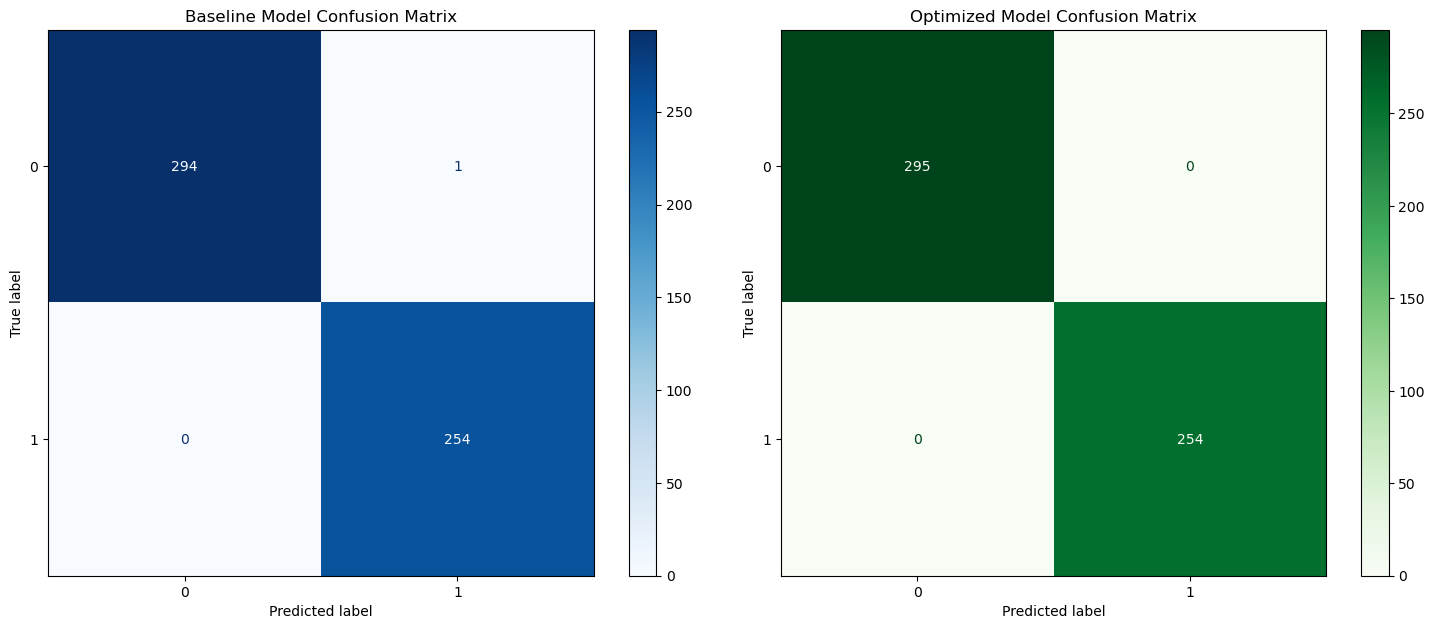


=== Model Comparison Report ===

Baseline Model Performance:
Accuracy: 0.9982
F2-Score: 0.9992

Optimized Model Performance:
Accuracy: 1.0000
F2-Score: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       295
           1       1.00      1.00      1.00       254

    accuracy                           1.00       549
   macro avg       1.00      1.00      1.00       549
weighted avg       1.00      1.00      1.00       549


Best Parameters:
algorithm: auto
leaf_size: 20
n_neighbors: 1
p: 1
weights: uniform


In [59]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, fbeta_score, make_scorer,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

def tune_model(X_train, y_train, X_test, y_test):
    base_clf = KNeighborsClassifier()
    
    param_grid = {
        'n_neighbors': list(range(1, 15)),
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'leaf_size': [20, 30, 40],
        'p': [1, 2]
    }
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)
    
    grid_search = GridSearchCV(
        estimator=base_clf,
        param_grid=param_grid,
        scoring=make_scorer(fbeta_score, beta=2),  # Now works
        cv=cv,
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    best_clf = grid_search.best_estimator_
    
    
    # Generate predictions
    base_preds = base_clf.fit(X_train, y_train).predict(X_test)
    optimized_preds = best_clf.predict(X_test)
    
    # Create visualization
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    
    # Confusion matrix comparison
    ConfusionMatrixDisplay.from_estimator(base_clf, X_test, y_test, 
                                        ax=ax[0], cmap='Blues')
    ax[0].set_title('Baseline Model Confusion Matrix')
    
    ConfusionMatrixDisplay.from_estimator(best_clf, X_test, y_test,
                                        ax=ax[1], cmap='Greens')
    ax[1].set_title('Optimized Model Confusion Matrix')
    
    plt.tight_layout()
    plt.show()
    
    # Print comprehensive report
    print("\n=== Model Comparison Report ===")
    print("\nBaseline Model Performance:")
    print(f"Accuracy: {accuracy_score(y_test, base_preds):.4f}")
    print(f"F2-Score: {fbeta_score(y_test, base_preds, beta=2):.4f}")
    
    print("\nOptimized Model Performance:")
    print(f"Accuracy: {accuracy_score(y_test, optimized_preds):.4f}")
    print(f"F2-Score: {fbeta_score(y_test, optimized_preds, beta=2):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, optimized_preds))
    
    print("\nBest Parameters:")
    for param, value in grid_search.best_params_.items():
        print(f"{param}: {value}")
    
    return best_clf

# Execute tuning
best_model = tune_model(X_train, y_train, X_test, y_test)
